In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('dark')

import json
import os
import datetime

from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import cairosvg
from PIL import Image
import albumentations as A
import cv2
import tensorflow as tf

2025-01-18 16:25:22.236272: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737217522.346711  163548 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737217522.377481  163548 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-18 16:25:22.614101: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Динамічне виділення пам'яті
    except RuntimeError as e:
        print(e)

In [3]:
with open("../configs/config.json", "r") as file:
    config = json.load(file)

# Виведення конфігурації
print(config)

{'data': {'raw_path': '../data/raw/svg', 'png_path': '../data/precessed/png_images', 'precessed_train_path': '../data/tfrec/train/', 'precessed_valid_path': '../data/tfrec/val/', 'class_names': ['airplane', 'alarm clock', 'angel', 'ant', 'apple', 'arm', 'armchair', 'ashtray', 'axe', 'backpack', 'banana', 'barn', 'baseball bat', 'basket', 'bathtub', 'bear (animal)', 'bed', 'bee', 'beer-mug', 'bell', 'bench', 'bicycle', 'binoculars', 'blimp', 'book', 'bookshelf', 'boomerang', 'bottle opener', 'bowl', 'brain', 'bread', 'bridge', 'bulldozer', 'bus', 'bush', 'butterfly', 'cabinet', 'cactus', 'cake', 'calculator', 'camel', 'camera', 'candle', 'cannon', 'canoe', 'car (sedan)', 'carrot', 'castle', 'cat', 'cell phone', 'chair', 'chandelier', 'church', 'cigarette', 'cloud', 'comb', 'computer monitor', 'computer-mouse', 'couch', 'cow', 'crab', 'crane (machine)', 'crocodile', 'crown', 'cup', 'diamond', 'dog', 'dolphin', 'donut', 'door', 'door handle', 'dragon', 'duck', 'ear', 'elephant', 'envelope

In [4]:
# Constants
IMAGE_SIZE = (config['model']['input_size'], config['model']['input_size'])
img_size = config['model']['input_size']
BATCH_SIZE = config['model']['batch_size']
NUM_CLASSES = config['model']['output_size']
PNG_DIR = config['data']['png_path']
TFREC_TRAIN_DIR = config['data']['precessed_train_path']
TFREC_VALID_DIR = config['data']['precessed_valid_path']
MODEL_FINAL_DIR = config['training']['final_model_dir']
class_names = sorted(os.listdir(PNG_DIR))

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance


# Функція для парсингу TFRecord
def parse_tfrecord_onehot(example_proto, num_classes):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([num_classes], tf.float32),
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.image.decode_jpeg(example['image'], channels=3)  # Декодуємо JPEG
    image = tf.image.convert_image_dtype(image, tf.float32)  # Конвертуємо в float32
    label = example['label']
    return image, label

# Завантажуємо TFRecord файли
def load_tfrecord_onehot_dataset(tfrecord_files, num_classes, batch_size=BATCH_SIZE):
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(lambda x: parse_tfrecord_onehot(x, num_classes), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def augment_image(image):
    # Випадкове горизонтальне віддзеркалення
    image = tf.image.random_flip_left_right(image)

    return image

# Функція для застосування аугментації під час завантаження даних
def augment_image_during_training(image, label):
    image = augment_image(image)
    return image, label


# Завантажуємо тренувальний датасет
train_tfrecord_files = [os.path.join(TFREC_TRAIN_DIR, f) for f in os.listdir(TFREC_TRAIN_DIR) if f.endswith('.tfrecord')]
train_dataset = load_tfrecord_onehot_dataset(train_tfrecord_files, NUM_CLASSES, batch_size=BATCH_SIZE)

# Застосовуємо аугментацію до тренувального датасету
train_dataset = train_dataset.map(
    augment_image_during_training,
    num_parallel_calls=tf.data.AUTOTUNE
)

# Додаємо батчування та prefetch для оптимізації
train_dataset = train_dataset.repeat().prefetch(tf.data.AUTOTUNE)

# Розраховуємо загальну кількість тренувальних зразків
total_train_samples = sum(1 for _ in tf.data.TFRecordDataset(train_tfrecord_files))


# Завантажуємо валідаційний датасет
val_tfrecord_files = [os.path.join(TFREC_VALID_DIR, f) for f in os.listdir(TFREC_VALID_DIR) if f.endswith('.tfrecord')]
val_dataset = load_tfrecord_onehot_dataset(val_tfrecord_files, NUM_CLASSES, batch_size=BATCH_SIZE)

# Додаємо батчування та prefetch для валідаційного датасету
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Розраховуємо загальну кількість валідаційних зразків
total_val_samples = sum(1 for _ in tf.data.TFRecordDataset(val_tfrecord_files))

steps_per_epoch = (total_train_samples + BATCH_SIZE - 1) // BATCH_SIZE
validation_steps = (total_val_samples + BATCH_SIZE - 1) // BATCH_SIZE




I0000 00:00:1737217527.630547  163548 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:05:00.0, compute capability: 8.6
2025-01-18 16:25:27.814746: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144
2025-01-18 16:25:29.429811: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-18 16:25:29.859283: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


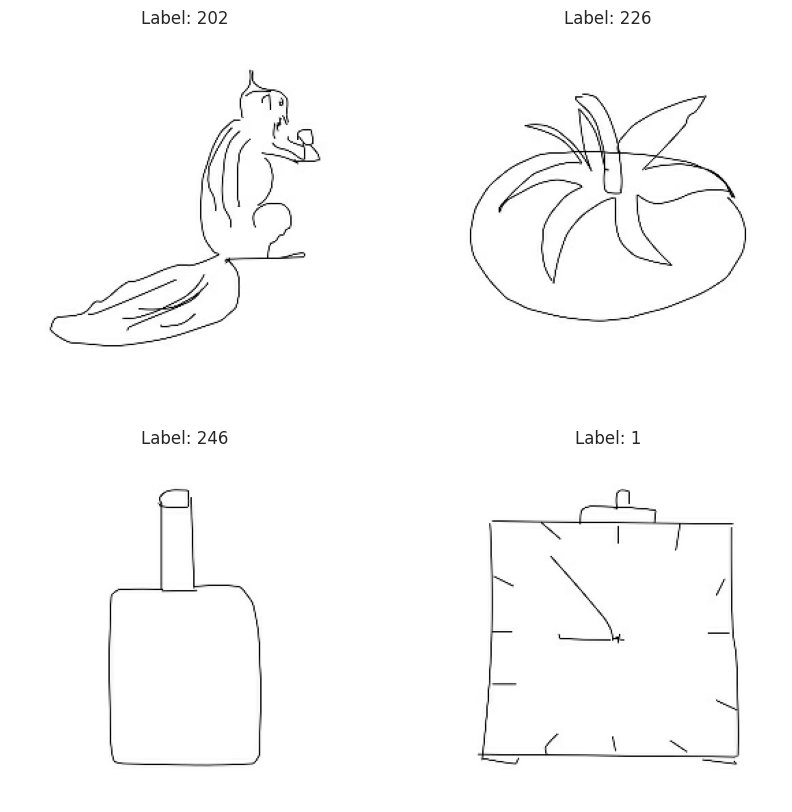

In [6]:
def visualize_images(dataset, num_images=4, is_onehot=False):
    # Беремо один батч з даними
    for images, labels in dataset.take(1):
        images = images.numpy()  # Конвертуємо тензори в NumPy
        labels = labels.numpy()

        # Перевіряємо, чи є дані в батчі
        batch_size = images.shape[0]
        if batch_size == 0:
            raise ValueError("Батч порожній, перевірте ваш датасет.")
        
        # Візуалізуємо тільки до num_images зображень
        num_images = min(num_images, batch_size)

        # Створюємо сітку для візуалізації
        plt.figure(figsize=(10, 10))
        for i in range(num_images):
            plt.subplot(2, 2, i + 1)
            
            # Отримуємо одне зображення
            image = images[i]

            # Відображення залежно від діапазону значень
            if image.max() > 1.0:
                plt.imshow(image.astype('uint8'))
            else:
                plt.imshow(image)
            
            # Отримуємо мітку
            if is_onehot:
                label = np.argmax(labels[i])
            else:
                label = labels[i]
            
            plt.title(f"Label: {label}")
            plt.axis('off')
        plt.show()

# Виклик функції з урахуванням батчів
visualize_images(train_dataset, is_onehot=True)


In [7]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# Функція для створення моделі

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # You can adjust this layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x)  # num_classes should match your dataset

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
import time
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

# Колбеки
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
]

# Етап 1: Навчання верхніх шарів
print("Етап 1: Навчання верхніх шарів...")
start_time = time.time()

history_stage_1 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,  # Кількість кроків на епоху
    validation_steps=validation_steps 
)

print(f"Час навчання етапу 1: {time.time() - start_time:.2f} секунд")

Етап 1: Навчання верхніх шарів...
Epoch 1/10


I0000 00:00:1737217532.731047  163663 service.cc:148] XLA service 0x7f721800eff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737217532.736170  163663 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-01-18 16:25:33.411222: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737217533.659036  163663 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-18 16:25:34.917027: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_734', 4 bytes spill stores, 4 bytes spill loads

2025-01-18 16:25:34.976394: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_734', 444 bytes

KeyboardInterrupt: 

In [ ]:
# Optionally unfreeze some layers
for layer in model.layers[-6:]:  # Unfreeze last 6 layers
    layer.trainable = True

# Recompile the model to apply the changes
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with a very low learning rate
history_stage_2 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,  # Кількість кроків на епоху
    validation_steps=validation_steps
)

Epoch 1/10


2025-01-18 15:49:35.437987: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1009', 104 bytes spill stores, 104 bytes spill loads



499/499 ━━━━━━━━━━━━━━━━━━━━ 70s 126ms/step - accuracy: 0.2282 - loss: 3.4639 - val_accuracy: 0.3310 - val_loss: 2.9478 - learning_rate: 1.0000e-05
Epoch 2/10


2025-01-18 15:50:41.914771: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1009', 92 bytes spill stores, 92 bytes spill loads



  1/499 ━━━━━━━━━━━━━━━━━━━━ 25:17 3s/step - accuracy: 0.2258 - loss: 3.4370

2025-01-18 15:50:44.624242: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7905652805037478153
2025-01-18 15:50:44.624332: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5782342593208176497


499/499 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.2258 - loss: 3.4370 - val_accuracy: 0.3280 - val_loss: 2.9484 - learning_rate: 1.0000e-05
Epoch 3/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 63s 127ms/step - accuracy: 0.3679 - loss: 2.7433 - val_accuracy: 0.3887 - val_loss: 2.6684 - learning_rate: 1.0000e-05
Epoch 4/10
  1/499 ━━━━━━━━━━━━━━━━━━━━ 48s 98ms/step - accuracy: 0.2903 - loss: 3.1798

2025-01-18 15:51:58.958517: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-18 15:51:58.958580: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7905652805037478153
2025-01-18 15:51:58.958616: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5782342593208176497


499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.2903 - loss: 3.1798 - val_accuracy: 0.3865 - val_loss: 2.6629 - learning_rate: 1.0000e-05
Epoch 5/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 63s 127ms/step - accuracy: 0.4267 - loss: 2.4752 - val_accuracy: 0.4100 - val_loss: 2.5186 - learning_rate: 1.0000e-05
Epoch 6/10
  1/499 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - accuracy: 0.3548 - loss: 3.0002

2025-01-18 15:53:13.818200: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7905652805037478153


499/499 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.3548 - loss: 3.0002 - val_accuracy: 0.4100 - val_loss: 2.5088 - learning_rate: 1.0000e-05
Epoch 7/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 64s 128ms/step - accuracy: 0.4596 - loss: 2.3086 - val_accuracy: 0.4257 - val_loss: 2.4051 - learning_rate: 1.0000e-05
Epoch 8/10
  1/499 ━━━━━━━━━━━━━━━━━━━━ 48s 98ms/step - accuracy: 0.3871 - loss: 2.8590

2025-01-18 15:54:28.663079: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7905652805037478153
2025-01-18 15:54:28.663170: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5782342593208176497


499/499 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.3871 - loss: 2.8590 - val_accuracy: 0.4277 - val_loss: 2.3990 - learning_rate: 1.0000e-05
Epoch 9/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 65s 129ms/step - accuracy: 0.4823 - loss: 2.1843 - val_accuracy: 0.4473 - val_loss: 2.3115 - learning_rate: 1.0000e-05
Epoch 10/10
  1/499 ━━━━━━━━━━━━━━━━━━━━ 47s 96ms/step - accuracy: 0.3226 - loss: 2.6968

2025-01-18 15:55:44.555813: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7905652805037478153
2025-01-18 15:55:44.555891: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5782342593208176497


499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.3226 - loss: 2.6968 - val_accuracy: 0.4445 - val_loss: 2.3085 - learning_rate: 1.0000e-05


In [13]:
# Збереження моделі
model.save(MODEL_FINAL_DIR + 'VGG19_day_fourv2.h5')


In [17]:
# # Розморожуємо всі шари базової моделі
# model.trainable = True

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-4,
#     decay_steps=steps_per_epoch * 5,
#     decay_rate=0.9
# )

# # Перекомпіляція з дуже низьким learning rate
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )


In [ ]:

# # Навчання з новими параметрами
# history_stage_3 = model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=20,
#     callbacks=callbacks,
#     steps_per_epoch=steps_per_epoch,  # Кількість кроків на епоху
#     validation_steps=validation_steps 
# )


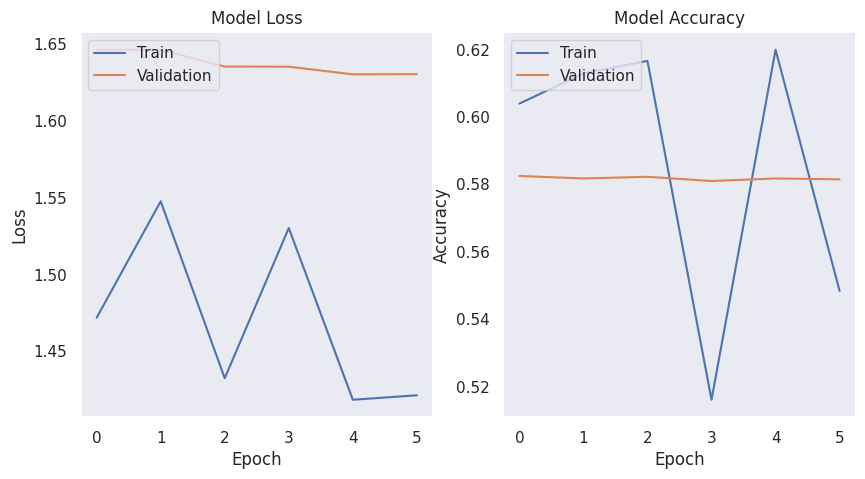

In [19]:
# #plotting loss and accuracy
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(history_stage_3.history['loss'])
# plt.plot(history_stage_3.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

# plt.subplot(1, 2, 2)
# plt.plot(history_stage_3.history['accuracy'])
# plt.plot(history_stage_3.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

In [20]:
# # Збереження моделі
# model.save(MODEL_FINAL_DIR + 'InceptionV3_day_four_v2.h5')
